Антон Суркис,
на степике [83694640](https://stepik.org/users/83694640),
на Kaggle [asurkis](https://www.kaggle.com/asurkis),
имя команды `Антон_Суркис_83694640`

Счет лучшей из посылок &mdash; 0.97662

Одна из аномалий &mdash; наибольший счет на Kaggle у меня был достигнут вообще без аугментаций набора данных, а с дополнением маленьких классов с помощью афинных координат и цветовых искажений он вообще получился почти худшим.

Копия лучшего самбита [на GitHub](https://github.com/asurkis/dls-homework-14/blob/0.97662/submission.csv)

In [49]:
# Процессор не потянет, пусть лучше упадет, если не может учиться на видеокарте
import torch
DEVICE = torch.device('cuda')

# Я запускал у себя на компьютере
# Если запускать в Colab, то потребуется подключить диск и настроить соответствующие пути
from pathlib import Path
paths_labeled = list(Path('train/simpsons_dataset').glob('**/*.jpg'))
paths_test = list(Path('testset/testset').glob('**/*.jpg'))

# LabelEncoder я решил оставить один на весь проект
# Так проще всего гарантировать, что нумерация классов во всех датасетах будет одинаковой
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder().fit([f.parent.name for f in paths_labeled])

from torchvision import transforms
# Приведение к формату входа нейросети
pre_transforms = transforms.Compose([
    transforms.Resize([224, 224]),
    # С двумя параметрами у Resize уже не нужно
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    # Коэффициенты для Normalize взяты из примера у TorchVision
    # Можно подобрать более точно
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Преобразования-аугментации
# Параметры взяты от балды, но тут по-другому особо никак
pre_transforms_multiply_1 = transforms.Compose([
    transforms.RandomAffine(7.5,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
    pre_transforms
])
pre_transforms_multiply_2 = transforms.Compose([
    transforms.RandomAffine(7.5,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05)),
    pre_transforms
])
pre_transforms_multiply_3 = transforms.Compose([
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
    pre_transforms
])

from sklearn.model_selection import train_test_split
paths_train, paths_val = train_test_split(paths_labeled)

from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision

class SimpsonsDataset(Dataset):
    def __init__(self, filepaths, has_labels=True, small_class=20):
        super().__init__()
        self.filepaths = sorted(filepaths)
        self.has_labels = has_labels
        self.labels = [label_encoder.transform([f.parent.name])[0] for f in self.filepaths] if has_labels else None
        # Кортеж (путь файла, метка, аугментации)
        self.additional = []
        # Есть классы, которых очень мало, и стоит размножить
        if self.has_labels:
            class_sizes = [sum(1 for l in self.labels if l == c) for c in range(len(label_encoder.classes_))]
            for i, path in enumerate(self.filepaths):
                if class_sizes[self.labels[i]] <= small_class:
                    self.additional.append((path, self.labels[i], pre_transforms_multiply_1))
                    self.additional.append((path, self.labels[i], pre_transforms_multiply_2))
                    self.additional.append((path, self.labels[i], pre_transforms_multiply_3))

    def __getitem__(self, index):
        path = None
        label = None
        transforms = None
        # Датасет с отражениями, но только не в тестовом режиме
        do_flip = self.has_labels and index % 2 == 1
        if self.has_labels:
            # Картинки по четным индексам, их отражения -- по нечетным
            index = index // 2
            if index < len(self.filepaths):
                # Картинки из основного набора
                path, label, transforms = self.filepaths[index], self.labels[index], pre_transforms
            else:
                # Аугментации
                path, label, transforms = self.additional[index - len(self.filepaths)]
        else:
            # В тестовом датасете меток нет
            path, transforms = self.filepaths[index], pre_transforms
        # Чтобы посмотреть на работу без аугментаций закомментируйте блок if-else выше и раскомментируйте код ниже
        # path = self.filepaths[index]
        # if self.has_labels:
        #     label = self.labels[i]
        # transforms = pre_transforms
        img = Image.open(path)
        # Чтобы посмотреть на работу без аугментаций закомментируйте блок if ниже
        if do_flip:
            img = img.transpose(method=Image.FLIP_LEFT_RIGHT)
        X = transforms(img)
        return (X, label) if self.has_labels else X

    def __len__(self):
        # Отражения занимают столько же места в пространстве индексов
        return (2 if self.has_labels else 1) * (len(self.filepaths) + len(self.additional))
        # Чтобы посмотреть на работу без аугментаций закомментируйте строку выше и раскомментируйте строку ниже
        # return len(self.filepaths)

dataset_train = SimpsonsDataset(paths_train)
dataset_val = SimpsonsDataset(paths_val)
dataset_test = SimpsonsDataset(paths_test, has_labels=False)

# Функция отображения для тензоров
import matplotlib.pyplot as plt
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Посмотрим на картинки и отражения

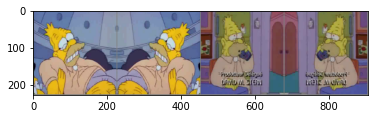

['abraham_grampa_simpson' 'abraham_grampa_simpson'
 'abraham_grampa_simpson' 'abraham_grampa_simpson']


In [41]:
images, labels = iter(DataLoader(dataset_train, batch_size=4)).next()
imshow(torchvision.utils.make_grid(images))
print(label_encoder.inverse_transform(labels))

Теперь на аугментированные картинки

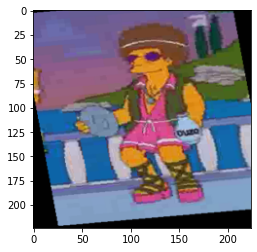

['disco_stu']


In [42]:
images, labels = dataset_train[2 * len(dataset_train.filepaths) + 2]
imshow(images)
print(label_encoder.inverse_transform([labels]))

Реализация прогона эпох обучения, валидации и теста:

In [43]:
from tqdm.notebook import tqdm

def train_one_epoch(model, data_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    model.train()
    for x_batch, y_batch in tqdm(data_loader, 'train epoch batches'):
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * x_batch.size(0)
        running_corrects += torch.sum(preds == y_batch).item()
        processed_size += x_batch.size(0)
    
    return running_loss / processed_size, running_corrects / processed_size

In [44]:
from tqdm.notebook import tqdm

def validate_one_epoch(model, data_loader, criterion):
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tqdm(data_loader, 'validate epoch batches'):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * x_batch.size(0)
            running_corrects += torch.sum(preds == y_batch).item()
            processed_size += x_batch.size(0)
    
    return running_loss / processed_size, running_corrects / processed_size

In [45]:
from tqdm.notebook import tqdm

def run_predict(model, data_loader):
    logits = []
    model.eval()
    with torch.no_grad():
        for x_batch in tqdm(data_loader, 'test epoch batches'):
            x_batch = x_batch.to(DEVICE)
            outputs = model(x_batch)
            preds = torch.argmax(outputs, 1)
            logits.append(preds)
    
    return torch.cat(logits)

In [46]:
from torch import nn
from torchvision import models

# Просто берем AlexNet
model = models.alexnet(pretrained=True).to(DEVICE)
# Заменяем последний слой
model.classifier[6] = nn.Linear(4096, len(label_encoder.classes_)).to(DEVICE)
# Замораживаем все, кроме последних 5
for p in model.features[:-5].parameters():
    p.requires_grad_(False)

# И дообучаем
history = []
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

loader_train = DataLoader(dataset_train, batch_size=256, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=256)

# У меня точность установилась где-то после 8 эпох
# Изначально прогонял 20
# Оставим 10 для надежности (и все равно оно обучается очень долго, ну что поделать)
for _ in tqdm(range(10), 'epochs'):
    train_loss, train_acc = train_one_epoch(model, loader_train, criterion, optimizer)
    val_loss, val_acc = validate_one_epoch(model, loader_val, criterion)
    history.append((train_loss, train_acc, val_loss, val_acc))

Посмотрим, как сетка обучалась

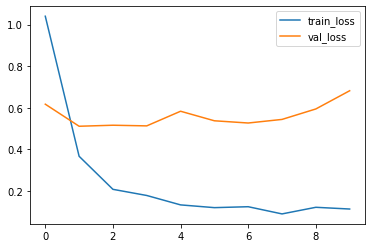

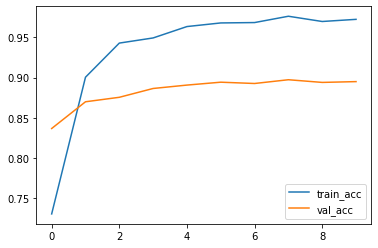

In [47]:
train_loss, train_acc, val_loss, val_acc = zip(*history)

plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.legend(loc='best')
plt.show()

plt.plot(train_acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.legend(loc='best')
plt.show()

Посчитаем тестовый вывод и сохраним его

In [50]:
preds = run_predict(model, DataLoader(dataset_test, batch_size=256))

In [51]:
import pandas as pd
pd.DataFrame({
    'Id': [f.name for f in dataset_test.filepaths],
    'Expected': label_encoder.inverse_transform(preds.cpu().numpy())
}).to_csv('submission.csv', index=None)

Костыль, можно было по-человечески написать функцию и вызвать ее,
или расписать все вручную и в предыдущих применениях, но этот код я добавил позже,
уже чтобы посчитать $F_1$

In [57]:
from tqdm.notebook import tqdm

logits = []
model.eval()
with torch.no_grad():
    for x_batch in tqdm(DataLoader(dataset_val, batch_size=256)):
        x_batch = x_batch[0].to(DEVICE)
        outputs = model(x_batch)
        preds = torch.argmax(outputs, 1)
        logits.append(preds)

preds_val = torch.cat(logits)

In [61]:
from sklearn.metrics import f1_score
score = f1_score(preds_val.cpu().numpy()[0:2 * len(dataset_val.filepaths):2], dataset_val.labels, average=None)
score, score.mean()

(array([0.97435897, 0.96774194, 1.        , 0.93103448, 0.98857143,
        1.        , 0.98807496, 0.97459584, 0.88888889, 0.98198198,
        0.66666667, 0.98333333, 0.93333333, 0.8       , 0.91176471,
        0.97793469, 0.99099099, 0.99189627, 0.88050314, 1.        ,
        0.97810219, 0.9375    , 0.99270073, 0.93023256, 0.91666667,
        0.98069498, 0.57142857, 0.97661623, 0.97413793, 0.94059406,
        0.875     , 0.97297297, 0.97577855, 0.86666667, 0.85714286,
        0.9787234 , 1.        , 0.99019608, 0.94117647, 0.9       ,
        1.        , 0.96551724]),
 0.9369885662510337)

$F_1$ несколько выше, чем функция потерь, такое же наблюдается и на Kaggle
Предполагаю, что тестовый датасет сильно пересекается с тренировочным,
поскольку его $F_1$ выше валидационной приблизительно на 2%